<a href="https://colab.research.google.com/github/krispad/Hello_Kris/blob/master/KA3_code_github_kp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd, plotly.express as px, plotly.graph_objects as go, datetime as datetime

Set up the drive location. Import data to the drive location

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Files from Yahoo Finance and rate data from the Federal Reserve in St. Louis, Missouri

In [3]:
from google.colab import files
uploaded = files.upload()

Saving us_ycr_1990_2024.csv to us_ycr_1990_2024.csv
Saving data_equities.csv to data_equities.csv


In [4]:
data_equities = pd.read_csv('/content/data_equities.csv')
us_ycr = pd.read_csv('/content/us_ycr_1990_2024.csv', usecols = ['Date', '1 Yr', '3 Yr','5 Yr', '7 Yr', '10 Yr'])

In [5]:
names = data_equities.columns
data_eq = data_equities[names[[2, 6, 8, 9, 10, 11]]].sort_values(by = ['type', 'symbol', 'Date'])
data_eq.columns

Index(['Date', 'Close', 'Volume', 'sector', 'symbol', 'type'], dtype='object')

In [6]:
data_eq['Date'] = pd.to_datetime(data_eq['Date'], errors = 'coerce')
data_eq['Date'].head()

58948   2006-05-05
58949   2006-05-08
58950   2006-05-09
58951   2006-05-10
58952   2006-05-11
Name: Date, dtype: datetime64[ns]

In [7]:

us_ycr['Date'] = pd.to_datetime(us_ycr['Date'], errors  = 'coerce')
us_ycr.dtypes

Date     datetime64[ns]
1 Yr            float64
3 Yr            float64
5 Yr            float64
7 Yr            float64
10 Yr           float64
dtype: object

In [8]:
names = us_ycr.duplicated()
sum(names)

0

In [9]:
comm_df = data_eq.merge(us_ycr, on = 'Date', how = 'inner', sort = True, validate = 'many_to_one')

In [10]:
comm_df.describe()


Date         Close        Volume  \
count                          50666  50666.000000  5.066600e+04   
mean   2010-06-22 14:01:11.337780736     76.916581  6.293990e+06   
min              1990-01-02 00:00:00      1.728395  0.000000e+00   
25%              2004-01-09 00:00:00     29.361771  7.338000e+05   
50%              2011-08-02 00:00:00     44.200001  3.134850e+06   
75%              2018-01-05 00:00:00     76.529179  7.651688e+06   
max              2024-05-08 00:00:00    588.750000  3.772638e+08   
std                              NaN     97.596517  1.034883e+07   

               1 Yr          3 Yr          5 Yr          7 Yr         10 Yr  
count  50659.000000  50659.000000  50659.000000  50659.000000  50659.000000  
mean       2.332879      2.728231      3.084893      3.379992      3.621700  
min        0.040000      0.100000      0.190000      0.360000      0.520000  
25%        0.280000      0.970000      1.560000      1.960000      2.230000  
50%        1.730000      2.240000      2.700000      3.030000      3.430000  
75%        4.430000      4.390000      4.460000      4.570000      4.650000  
max        8.640000      9.110000      9.100000      9.120000      9.090000  
std        2.144202      2.037257      1.923920      1.844665      1.762007

Plots by equity type (i.e. stocks and etfs)


In [11]:
def yc_eq(data, eq_type, period):
    ''' data: data containing the interest rates and the equities over a Date range
        eq_type : string, equity type i.e. 'stock' or 'etf'
        period : interest rate period , 1, 3, 7, 10, 20 years
    '''
    import numpy as np
    from scipy.interpolate import UnivariateSpline
    import matplotlib.pyplot as plt

    import datetime
    eq_dat = data[['Date', period, 'type', 'symbol', 'sector', 'Close'] ]
    eq_dat = eq_dat[eq_dat['type'] == eq_type] #'etf']
    #eq_dat = eq_dat.sort_values(by = ['symbol', 'Date'])

    # Spline interpolation
    # imputation
    x = range(0, eq_dat.shape[0]) # x has to be s.i. , that is the reason for using the range
    y = pd.to_numeric(eq_dat[period], errors = 'coerce')


    # Dealing with nan values
    from sklearn.impute import SimpleImputer
    X = y.array.reshape(-1, 1) # Changing the Pandas Series to a numpy array and reshaping
    # nan = np.nan
    imputer = SimpleImputer(missing_values = np.nan,  strategy = 'most_frequent')
    Y = imputer.fit_transform(X)
    eq_dat[period] = Y

    # Ensuring the transformed values are numeric
    y = pd.to_numeric(eq_dat[period], errors = 'coerce')
    # Applying the spline fit

    spline = UnivariateSpline(x, y, s = 14000)
    x_spline = np.linspace(0, eq_dat.shape[0], eq_dat.shape[0])
    y_spline = spline(x_spline)
    #plots
    fig = plt.figure()
    plt.subplots_adjust(bottom=0.25)

    ax = fig.subplots()

    x_new = eq_dat['Date']
    ax.plot(x_new, y,'b', x_new, y_spline, 'r'
        , eq_dat.loc[eq_dat['symbol'] =='ITB',  'Date'],  eq_dat.loc[eq_dat['symbol'] =='ITB',  'Close']/50, 'g'
        , eq_dat.loc[eq_dat['symbol'] =='ibb', 'Date'], eq_dat.loc[eq_dat['symbol'] == 'ibb', 'Close']/50,'orange'
        , eq_dat.loc[eq_dat['symbol'] =='ixc', 'Date'], eq_dat.loc[eq_dat['symbol'] == 'ixc', 'Close']/50,'purple'
        , eq_dat.loc[eq_dat['symbol'] =='iyf', 'Date'], eq_dat.loc[eq_dat['symbol'] == 'iyf', 'Close']/50,'black')
    ax.tick_params(axis = 'x', rotation = 70)
    plt.legend(labels = ['10yr int. rates', 'int.rate spline', 'Cls.Val.(scaled)"ITB":Consumer_Cyclicals'
                          , 'Cls.Val.(scaled) "ibb":Energy','Cls.Val.(scaled) "ixc":Finance'
                          , 'Cls.Val.(scaled) "iyf" Health']
               ,labelcolor = ['b', 'r', 'g', 'orange', 'purple', 'black']
               ,loc = 'best', fontsize = 'small', frameon = False
              )
    plt.title(f'{eq_type} per Sector vs. {period} interest rates')

    plt.show()

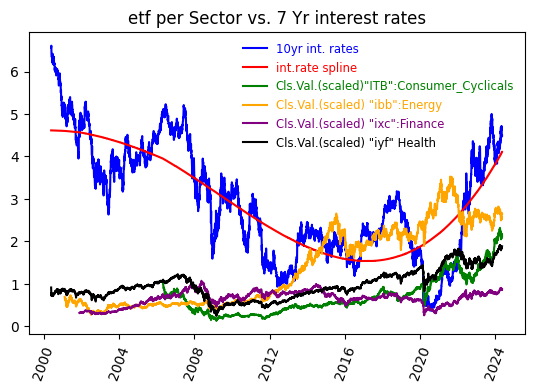

In [12]:
yc_eq(data = comm_df, eq_type = 'etf', period = '7 Yr')

In [13]:
def data_impute(data, period):
    '''impute missing values in the numeric columns of the data
       period represents a string indicating the interest rate period, eg. 1 Yr, 3 Yr, etc. --- the values are numeric
    '''


    # imputation
    x = range(0, data.shape[0]) # x has to be s.i.; a reason for using the range instead of 'Date'
    y = pd.to_numeric(data[period], errors = 'coerce')

    # Dealing with nan values
    from sklearn.impute import SimpleImputer
    X = y.array.reshape(-1, 1) # Changing the Pandas Series to a numpy array and reshaping
    # nan = np.nan
    imputer = SimpleImputer(missing_values = np.nan,  strategy = 'most_frequent')
    Y = imputer.fit_transform(X)
    data[period] = Y

    # Ensuring the transformed values are numeric
    y = pd.to_numeric(data[period], errors = 'coerce')
    return y, data

def data_spline(data, period):
    from scipy.interpolate import UnivariateSpline
    # Applying the spline fit
    y, data = data_impute(data, period)
    n  = data.shape[0]
    x = range(0, n)

    spline = UnivariateSpline(x, y, s = int(n/2))
    x_spline = np.linspace(0, n, n)
    y_spline = spline(x_spline)
    return y, y_spline

def data_plot(data, period, eq_type):
    ''' eq_type can take on the strings  'stock' or 'etf'
        type is a type of equity, that is 'stock' or 'etf'
        'period' is the interest rate period
    '''
    _ , data = data_impute(data, period)

    y, y_spline = data_spline(data, period)
    import matplotlib.pyplot as plt

    #symbols of equity
    eq_symbol =  data.loc[data['type'] == eq_type, 'symbol'].str.lower().unique() # returned in order of appearance.

    a = data['symbol']

    # sector
    eq_sector = data['sector'].str.lower().unique() # sectors are arranged in order of appearance

    #plots
    fig = plt.figure()
    plt.subplots_adjust(bottom=0.25)

    ax = fig.subplots()

    x_new = np.array(data['Date'])


    colors = ['green', 'orange', 'purple', 'black']
    ymean = y.mean()
    data['symbol'] = data['symbol'].str.lower()
    scale = list(data.groupby('symbol')['Close'].apply(lambda x: x.mean()))
    ax.plot(x_new, y, 'b', x_new, y_spline, 'r')
    # Note that we make the implicit assumption that len(eq_sector) = len(eq_symbol)
    legend_label = []
    for k in range(len(eq_symbol)):
        ax.plot(data.loc[a == eq_symbol[k], 'Date'], data.loc[a == eq_symbol[k], 'Close']/(scale[k]/ymean), colors[k])
        legend_label.append(f'Cls.Val.(scaled){eq_symbol[k]}:{eq_sector[k]}')


    ax.tick_params(axis = 'x', rotation = 70)
    plt.legend(labels = ['10yr int. rates', 'int.rate spline'] + legend_label, labelcolor = ['b', 'r'] + colors
               ,loc = 'best', fontsize = 'small', frameon = False)

    plt.title(f'{eq_type} per Sector vs. {period} interest rates')

    plt.show()


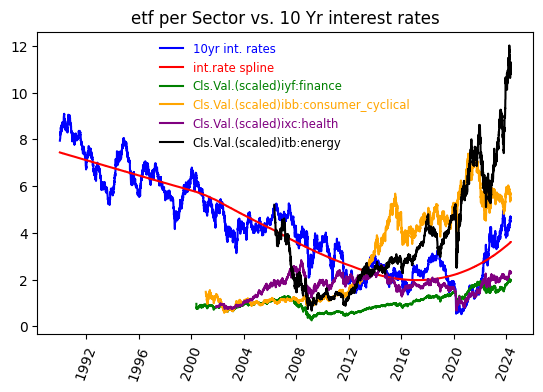

In [15]:
data_plot(data = comm_df, period = '10 Yr', eq_type = 'etf')

In [16]:
def plotly_representation(data, period, eq_type):
    import plotly.graph_objects as go
    y, y_spline = data_spline(data, period)
    #symbols of equity
    eq_symbol =  data.loc[data['type'] == 'etf', 'symbol'].str.lower().unique() # returned in order of appearance.

    a = data['symbol']

    # sector
    eq_sector = data['sector'].str.lower().unique() # sectors are arranged in order of appearance

    x_new = np.array(data['Date'])

    colors = ['green', 'orange', 'purple', 'black']
    ymean = y.mean()
    data['symbol'] = data['symbol'].str.lower()
    scale = list(data.groupby('symbol')['Close'].apply(lambda x: x.mean()))
    go_data = []
    for k in range(len(eq_sector)):
        go_data.append(go.Scatter(x = data.loc[data['symbol'] == eq_symbol[k], 'Date'],
                                  y = data.loc[data['symbol'] == eq_symbol[k], 'Close']/(scale[k]/ymean),
                                  name = f'{eq_sector[k]}:{eq_symbol[k]}'
                                 )
                      )

    plot = go.Figure(data=[go.Scatter(x = data['Date'], y = y, name = 'y_int_rate'),
                           go.Scatter(x = data['Date'], y = y_spline, name = 'yr_spline')] + go_data)
    ''',
                           go.Scatter(x = df.loc[df['symbol'] =='psx','Date'], y = df.loc[df['symbol'] =='psx','Close']/50, name = 'Energy Stock: psx'),
                           go.Scatter(x = df.loc[df['symbol'] =='mrk','Date'], y = df.loc[df['symbol'] =='mrk','Close']/50, name = 'Health Stock: mrk'),
                           go.Scatter(x = df.loc[df['symbol'] =='HD','Date'], y = df.loc[df['symbol'] =='HD','Close']/50 , name = 'Consumer_Cyclicals: HD'),
                           go.Scatter(x = df.loc[df['symbol'] =='C','Date'], y = df.loc[df['symbol'] =='C','Close']/50, name = 'Finance Stock: C')
                          ]
                   )'''
    # title = 'Scaled stock prices using 4 arbitrariy selected stocks in 4 sectors compared to a UnivariateSpline through 10yr interest rates',
    plot.update_layout(title = f'Four scaled stock prices vs. a UnivariateSpline through {period} interest rates',
                       xaxis=dict(
                                   rangeselector=dict(
                                                       buttons=list([
                                                                    dict(count=1,step="day",stepmode="backward")
                                                                    ])
                                                     ),
                                   rangeslider=dict(visible=True)
                                 )

                     )
    plot.update_legends(patch = dict(visible = True))
    plot.show()

In [17]:
plotly_representation(data = comm_df, period = '10 Yr', eq_type = 'stock')